Data: http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/A%2BA/563/A21

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from batman import TransitParams
params = TransitParams()
params.per = 1.58040417
params.t0 = 2454980.74900
params.inc = 88.47
params.a = 14.45
params.rp = 0.1160
params.duration = 0.03620
params.b = 0.385

In [3]:
bjd, flux, err, x, y, fwhmx, fwhmy, bg, exptime = np.loadtxt('gj1214.tsv', skiprows=500, unpack=True)
jd = bjd + 2450000

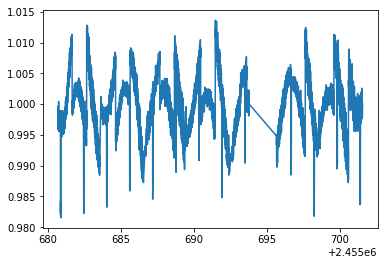

In [4]:
plt.plot(jd, flux)

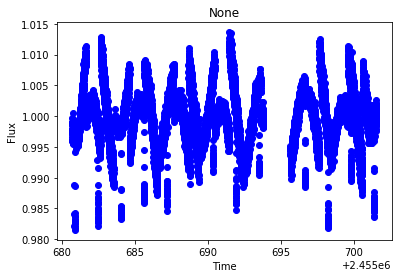

In [5]:
import sys

sys.path.insert(0, '/Users/bmmorris/git/friedrich/')
from friedrich.lightcurve import LightCurve
from friedrich.lightcurve import concatenate_transit_light_curves

lc = LightCurve(jd, flux)
lc.plot()
#plt.xlim([5680, 5700])

In [6]:
split = LightCurve(**lc.mask_out_of_transit(params, oot_duration_fraction=1))
transits = split.get_transit_light_curves(params)
all_transits = concatenate_transit_light_curves(transits)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/time/core.py:880: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/time/core.py:881: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/friedrich/friedrich/lightcurve.py:889: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/friedrich/friedrich/lightcurve.py:890: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/friedrich/friedrich/lightc

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12307 but corresponding boolean dimension is 73
  if sys.path[0] == '':


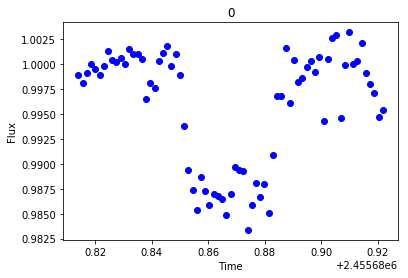

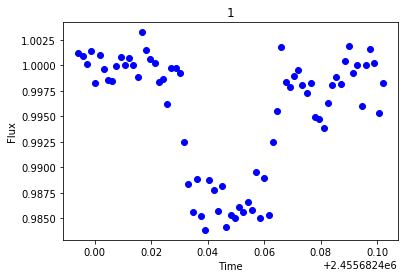

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12307 but corresponding boolean dimension is 71
  if sys.path[0] == '':


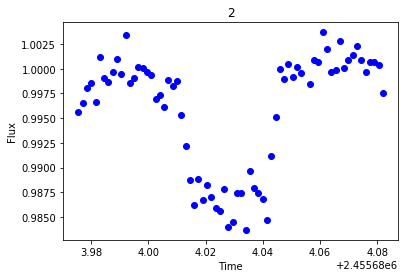

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12307 but corresponding boolean dimension is 72
  if sys.path[0] == '':


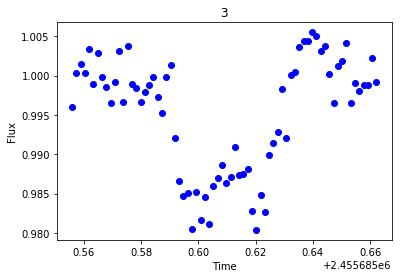

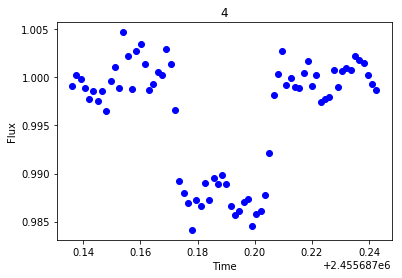

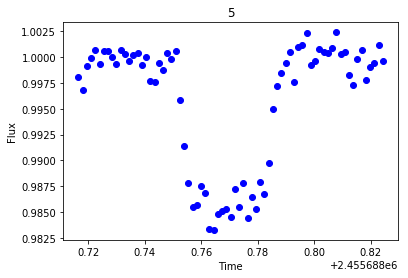

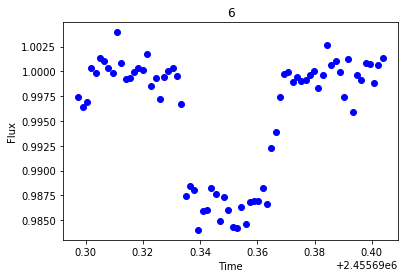

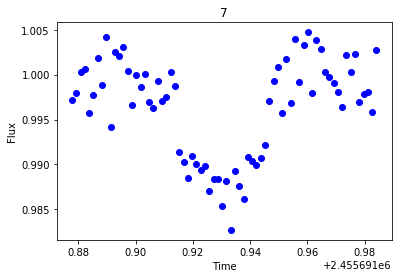

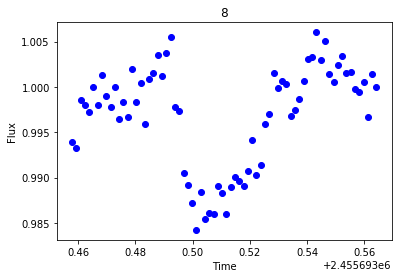

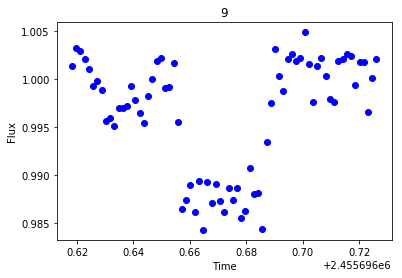

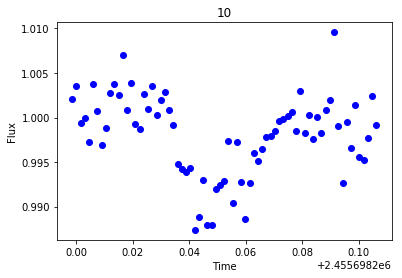

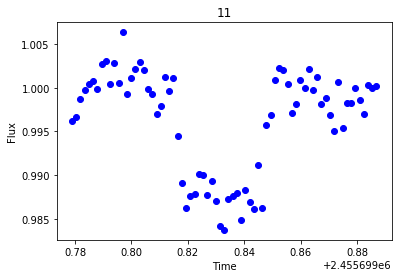

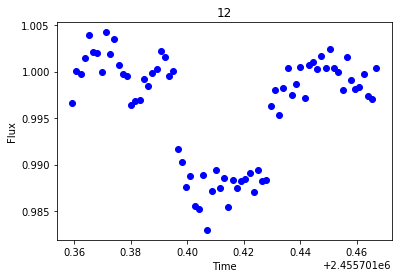

In [7]:
for transit in transits:
#     transit.fluxes /= np.median(transit_masked['fluxes'])

    condition = np.in1d(jd, transit.times.jd)
    
    X_all = np.vstack([x[condition], y[condition], fwhmx[condition], 
                       fwhmy[condition], bg[condition]]).T

    oot = np.ones_like(x[condition]).astype(bool)
    X = X_all[oot, :]

    omega = np.diag(err[oot]**2)
    omega_inv = np.linalg.inv(omega)

    V = np.linalg.inv(X.T @ omega_inv @ X)
    beta = V @ X.T @ omega_inv @ transit.fluxes[oot]

    regressed_lc = transit.fluxes - (X_all @ beta) + 1
    
    transit.fluxes = regressed_lc
    transit_masked = transit.mask_in_transit(params)
    transit.fluxes /= np.median(transit_masked['fluxes'])
    
    transit.plot()
all_transits = concatenate_transit_light_curves(transits)

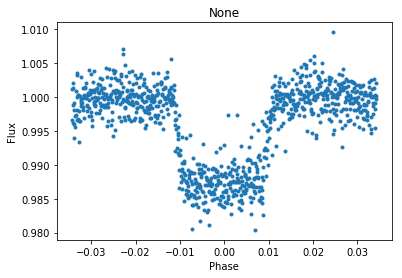

In [8]:
all_transits.plot(params, phase=True, plot_kwargs=dict(marker='.', lw=0))

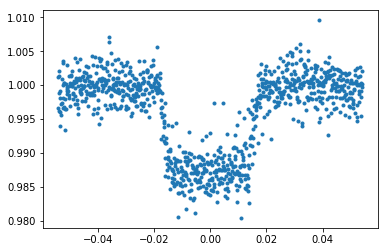

In [9]:
phases = ((all_transits.times.jd - params.t0) % params.per)
phases[phases > params.per/2] -= params.per
all_fluxes = all_transits.fluxes[np.argsort(phases)]
phases = phases[np.argsort(phases)]
plt.plot(phases, all_fluxes, '.')

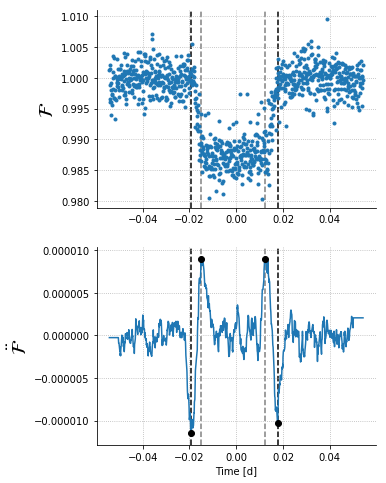

In [13]:
from scipy.signal import savgol_filter

filtered = savgol_filter(all_fluxes, 71, 2, deriv=2)

times = phases

fig, ax = plt.subplots(2, 1, figsize=(5, 8))
# ax[0].plot(times, spotless_lc, label='Spotless')
# ax[0].plot(times, spotted_lc, label='Spotted')
ax[0].plot(phases, all_fluxes, '.')
from scipy.signal import savgol_filter

n = len(times)//2
mins = [np.argmin(filtered[:n]), n + np.argmin(filtered[n:])]
maxes = [np.argmax(filtered[:n]), n + np.argmax(filtered[n:])]

ax[1].plot(times, filtered)

t14 = -1*np.diff(times[mins])[0]
t23 = -1*np.diff(times[maxes])[0]

ax[1].scatter(times[mins], filtered[mins], color='k', zorder=10)
ax[1].scatter(times[maxes], filtered[maxes], color='k', zorder=10)

for ts, c in zip([times[mins], times[maxes]], ['k', 'gray']):
    for t in ts:
        ax[0].axvline(t, ls='--', color=c, zorder=-10)
        ax[1].axvline(t, ls='--', color=c, zorder=-10)

for axis in fig.axes:
    axis.grid(ls=':')
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.legend()
        
ax[0].set_ylabel('$\mathcal{F}$', fontsize=20)
ax[1].set_ylabel('$\ddot{\mathcal{F}}$', fontsize=20)
ax[1].set_xlabel('Time [d]')
fig.savefig('gj1214.pdf', bbox_inches='tight')
plt.show()

In [14]:
one_plus_k = np.sqrt((np.sin(t14*np.pi/params.per) * np.sin(np.radians(params.inc)) * params.a)**2 + params.b**2)
one_minus_k = np.sqrt((np.sin(t23*np.pi/params.per) * np.sin(np.radians(params.inc)) * params.a)**2 + params.b**2)
k = (one_plus_k - one_minus_k)/2
print(k, 0.11694)

0.121798797563 0.11694


11 -262.690559106
13 114.817910223
15 -177.252329868
17 100.107865282
19 -42.280845768
21 277.185506836
23 -7.72178788781
25 -172.361491112
27 267.428449738
29 -247.896883694
31 -245.034489223
33 59.8174461332
35 -41.7058346542
37 -39.4777770994
39 37.9585475628
41 61.9436233703
43 57.9487059773
45 54.2203825394
47 64.1981808336
49 58.5751066114
51 60.9185743994
53 60.7623954483
55 69.3298687317
57 70.3957434691
59 67.339132223
61 65.1684375363
63 65.2349137571
65 65.2349137571
67 60.5608396242
69 82.5725918926
71 80.0913725572
73 86.9638555118
75 78.3669003981
77 80.5483010737
79 76.3708237812
81 84.7419723128
83 81.2975130562
85 93.6160081936
87 91.0924679752
89 91.782428445
91 94.7821556042
93 95.9964854024
95 99.3511998436
97 100.841838913
99 105.294143954
101 105.429529799
103 111.617629893
105 111.82227999
107 116.40956391
109 116.992821614
111 123.867927399
113 132.097656727
115 132.571136624
117 136.692701029
119 137.320958435
0.0976417889422 0.0216643820057


(0, 0.25)

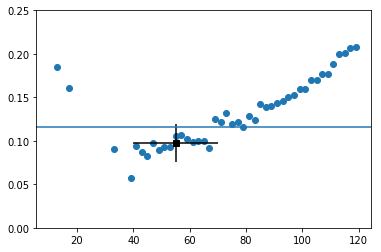

In [41]:

ws = []
ks = []

for w in np.arange(11, 121, 2):
    filtered = savgol_filter(all_fluxes, w, 2, deriv=2)
    n = len(times)//2
    mins = [np.argmin(filtered[:n]), n + np.argmin(filtered[n:])]
    maxes = [np.argmax(filtered[:n]), n + np.argmax(filtered[n:])]
    t14 = abs(np.diff(times[mins])[0])
    t23 = abs(np.diff(times[maxes])[0])
    one_plus_k = np.sqrt((np.sin(t14*np.pi/params.per) * np.sin(np.radians(params.inc)) * params.a)**2 + params.b**2)
    one_minus_k = np.sqrt((np.sin(t23*np.pi/params.per) * np.sin(np.radians(params.inc)) * params.a)**2 + params.b**2)
    k = (one_plus_k - one_minus_k)/2
    print(w, (t14 - t23) * len(times) / times.ptp())
    ws.append(w)
    ks.append(k)

ws = np.array(ws)
ks = np.array(ks)

plt.scatter(ws, ks)

wmid = 55
k = np.median(ks[(ws < 70) & (ws > 40)])
kerr = np.ptp(ks[(ws < 70) & (ws > 40)])/2
plt.errorbar(wmid, k, yerr=kerr, xerr=15, fmt='s', color='k')

print(k, kerr)
plt.axhline(params.rp)
plt.ylim([0, 0.25])

In [31]:

w = 79
filtered = savgol_filter(all_fluxes, w, 2, deriv=2)
n = len(times)//2
mins = [np.argmin(filtered[:n]), n + np.argmin(filtered[n:])]
maxes = [np.argmax(filtered[:n]), n + np.argmax(filtered[n:])]
t14 = abs(np.diff(times[mins])[0])
t23 = abs(np.diff(times[maxes])[0])
one_plus_k = np.sqrt((np.sin(t14*np.pi/params.per) * np.sin(np.radians(params.inc)) * params.a)**2 + params.b**2)
one_minus_k = np.sqrt((np.sin(t23*np.pi/params.per) * np.sin(np.radians(params.inc)) * params.a)**2 + params.b**2)
k = (one_plus_k - one_minus_k)/2

abs(k - params.rp)

0.00011976433001777143

In [38]:
(t14 - t23) * len(times) / times.ptp() #* len(times)

76.370823781233668